# Spectral Axes, Velocity Frames and Conventions in `dysh`
----------------------------------

This notebook shows how to change spectral axes to represent different rest frames and Doppler conventions.

In [1]:
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.download import from_url
from pathlib import Path

## Data Retrieval

Download the example SDFITS data, if necessary.

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/positionswitch/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/AGBT05B_047_01.raw.acs.fits"
savepath = Path.cwd() / "data"
filename = from_url(url, savepath)

### Load the file

In [3]:
sdfits = GBTFITSLoad(filename)
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.343112,18.64274
1,52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.930571,18.787219
2,53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.330491,18.356075
3,54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.915725,18.492742
4,55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.304237,18.057533
5,56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.890603,18.186034
6,57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.327548,17.385267
7,58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.919161,17.494902


## Data Reduction

Next we fetch and calibrate the position switched data. We will use this data to show how to change rest frames and Doppler conventions.

In [4]:
psscan = sdfits.getps(scan=51, ifnum=0, plnum=0, fdnum=0)

Create the time-averaged spectrum.

In [5]:
ta = psscan.timeaverage()

-----------------------
## Example 1: Changing the x-axis of a spectrum plot
Note this changes the axis of the plot but does not affect the underlying Spectrum object.


### Default Rest Frame

The default plot uses the frequency frame and Doppler convention found in the SDFITS file.
In this case, that is topocentric frame and the optical convention.

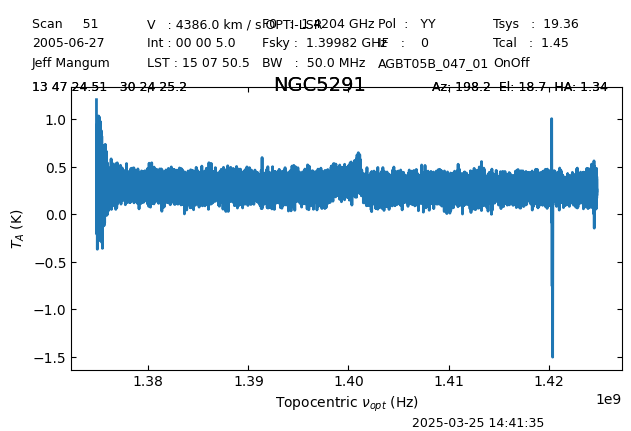

In [6]:
ta.plot()

### Change Rest Frame
You can change the velocity frame by supplying one of the [built-in astropy coordinate frames](https://docs.astropy.org/en/stable/coordinates/index.html#built-in-frame-classes). These are specified by string name.

For example, to plot in the barycentric frame use `"icrs"`. The change here is small, a shift of 22.8 kHz. 

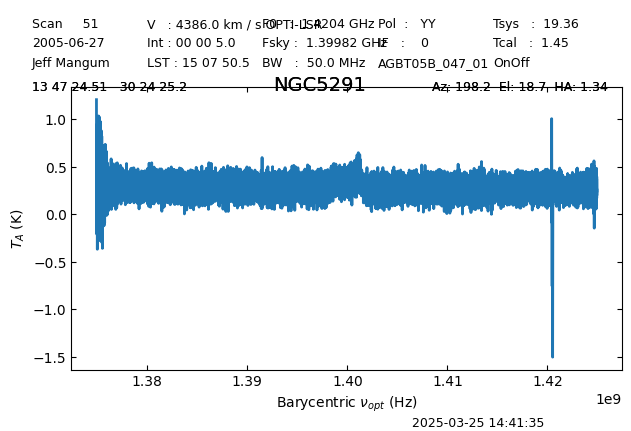

In [7]:
ta.plot(vel_frame='icrs')

In addition to the `astropy` frame names, we also allow `'topo'` and `'topocentric'`.

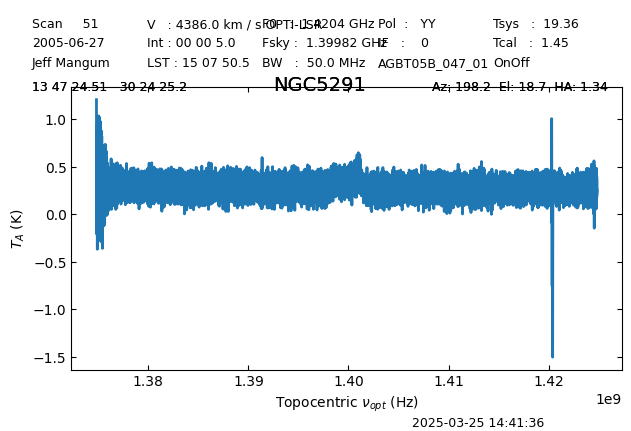

In [8]:
ta.plot(vel_frame='topo')

### Doppler Convention 
One can also change the Doppler convention between `radio`, `optical`, and `relativistic`.
Here we also change the x-axis to velocity units and use LSRK frame.

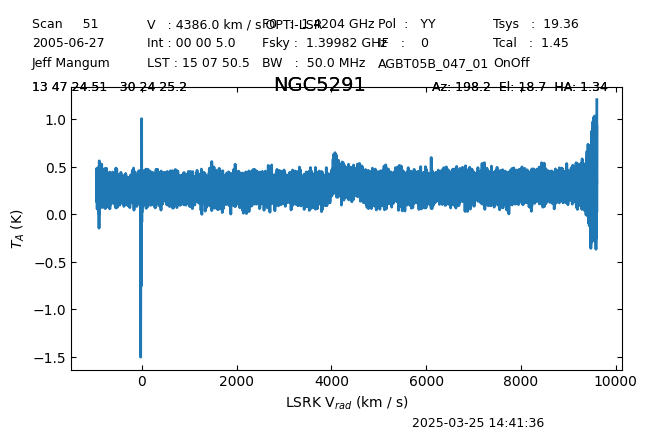

In [9]:
ta.plot(vel_frame='lsrk', doppler_convention='radio', xaxis_unit='km/s')

Finally, if you plot velocity units on the x-axis with no `vel_frame` given, it will default to the 
frame decoded from the VELDEF keyword in the header if present.

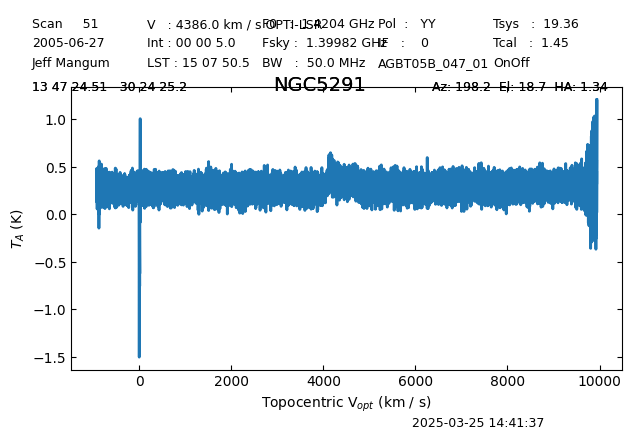

In [10]:
ta.plot(xaxis_unit="km/s")

---------------


## Example 2: Changing the spectral axis of the Spectrum.
There are two ways to accomplish this.  One returns a copy of the original Spectrum with the new spectral axis; 
the other changes the spectral axis in place.

### A.   Return a copy of the spectrum using [`Spectrum.with_frame()`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.with_frame)

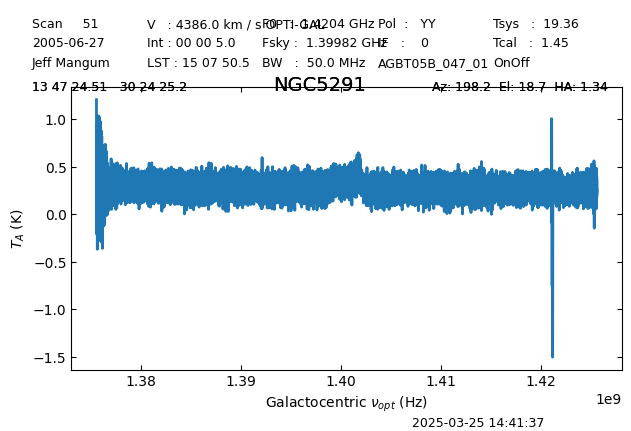

The new spectral axis frame is galactocentric


In [11]:
newspec = ta.with_frame('galactocentric')
newspec.plot()
print(f"The new spectral axis frame is {newspec.velocity_frame}")

One can see that the spectral axis of the new spectrum is different.

In [12]:
ta.spectral_axis-newspec.spectral_axis

<Quantity [-739929.54722381, -739928.75481129, -739927.96239853, ...,
           -713966.1467061 , -713965.35429358, -713964.56188083] Hz>

### B.   Change the spectral axis in place using [`Spectrum.set_frame()`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.set_frame)

In [13]:
sa = ta.spectral_axis
ta.set_frame('gcrs')
print(f"Changed spectral axis frame to  {ta.velocity_frame}")

Changed spectral axis frame to  gcrs


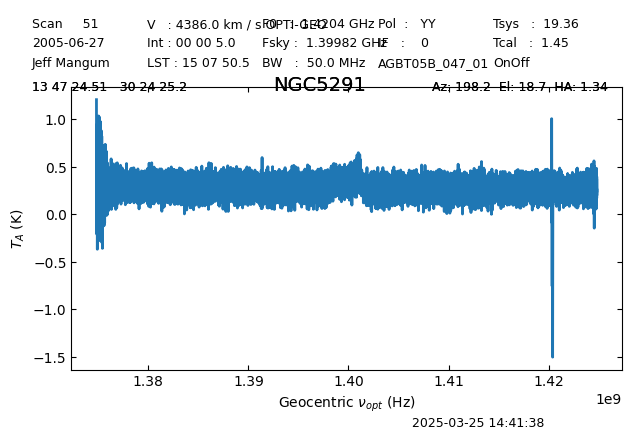

In [14]:
ta.plot()

Here the original the spectral axis has changed

In [15]:
ta.spectral_axis - sa

<Quantity [511.56335759, 511.56280971, 511.56226182, ..., 493.6131022 ,
           493.61255431, 493.61200643] Hz>

In [16]:
ta.target

<SkyCoord (FK5: equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
    (206.85210758, -30.40701531, 1000000.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0., 0., 4386.)>

In [17]:
ta.observer

<GCRS Coordinate (obstime=2005-06-27T02:05:58.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (x, y, z) in m
    (-3418483.37116048, -3651331.51587568, 3945691.32972075)
 (v_x, v_y, v_z) in km / s
    (-4.3110922e-08, 9.51169059e-08, 6.55464828e-08)>

-----------

## Other useful functions

### Spectral Axis Conversion
Convert the spectral axis to any units, frame, and convention with [`Spectrum.velocity_axis_to`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.spectrum.Spectrum.velocity_axis_to). dysh understands some common synonyms like 'heliocentric' for astropy's 'hcrs'.

In [18]:
ta.velocity_axis_to(unit="pc/Myr", toframe='heliocentric', doppler_convention='radio')

<SpectralAxis 
   (observer: <ICRS Coordinate: (x, y, z) in m
                  (1.51192456e+10, -1.38756853e+11, -6.01691775e+10)
               (v_x, v_y, v_z) in km / s
                  (0., 0., 0.)>
    target: <FK5 Coordinate (equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
                (206.85210758, -30.40701531, 1000000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (0., 0., 4386.)>
    observer to target (computed from above):
      radial_velocity=4385.999999999997 km / s
      redshift=0.014738724592067598
    doppler_rest=1420405000.0 Hz
    doppler_convention=radio)
  [-977.01109538, -976.68170048, -976.35230558, ..., 9815.61280575,
   9815.94220065, 9816.27159555] pc / Myr>

### Spectral Shift 
Shift a spectrum in place to a given radial velocity or redshift with [`Spectrum.shift_spectrum_to`](https://specutils.readthedocs.io/en/stable/api/specutils.Spectrum1D.html#specutils.Spectrum1D.shift_spectrum_to)

In [19]:
print(f"before shift {ta.spectral_axis}")
ta.shift_spectrum_to(radial_velocity=0*u.km/u.s)
print(f"after shift {ta.spectral_axis}")

before shift [1.42481735e+09 1.42481582e+09 1.42481430e+09 ... 1.37482191e+09
 1.37482038e+09 1.37481886e+09] Hz
after shift [1.44593293e+09 1.44593139e+09 1.44592984e+09 ... 1.39519657e+09
 1.39519502e+09 1.39519347e+09] Hz


### Spectral Axis in Wavelengths
The default is angstrom, use [Quantity.to](https://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity.to) to convert to other units.

In [20]:
ta.wavelength.to('cm')

<SpectralAxis 
   (observer: <GCRS Coordinate (obstime=2005-06-27T02:05:58.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, m)
                  (226.88638534, 38.2681561, 6370771.57549705)
               (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                  (-33132.93080836, 103576.96454981, -4.73214035e-08)>
    target: <FK5 Coordinate (equinox=J2000.000): (ra, dec, distance) in (deg, deg, kpc)
                (206.85210758, -30.40701531, 1000000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (3.83414117e-18, -7.07577549e-19, -23.96240223)>
    observer to target (computed from above):
      radial_velocity=-7.7229733719264e-09 km / s
      redshift=-2.5757174171303632e-14
    doppler_rest=1420405000.0 Hz
    doppler_convention=optical)
  [20.73349676, 20.73351897, 20.73354117, ..., 21.487471  , 21.48749485,
   21.48751869] cm>

### Plot in Channels
Also, you can plot the x-axis in channel units

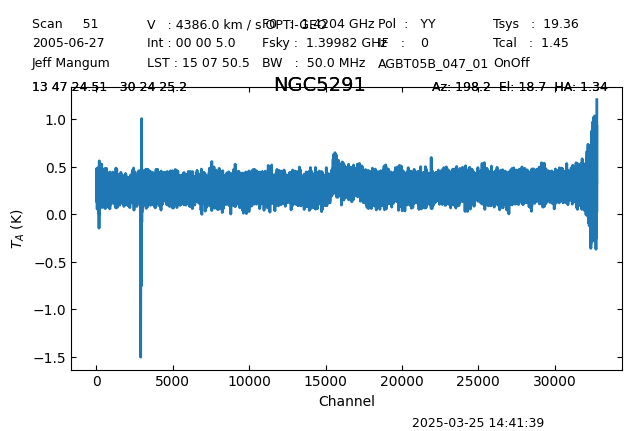

In [21]:
ta.plot(xaxis_unit='chan')